In [49]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import read_data

Lineare Regression auf den Timeseries sowohl bei proteinen als auch bei clinical data.
Gibt es dann in der slope und interception point zusammenhaenge?
Kann man besseres als lineare regression machen? Z.b. clustering?

In [37]:
data = read_data.data()
prot, pept = data.x_data_3d()
clin = data.y_data_3d()

D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:61: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_uniprot = pd.pivot_table(df_uniprot, index='patient_id', columns=['visit_month'])
D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:63: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_peptide = pd.pivot_table(df_peptide, index='patient_id', columns=['visit_month'])
D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:72: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  return pd.p

In [41]:
def calc_lingress(row):
    if row.isnull().all():
        return pd.Series([np.nan, np.nan, np.nan])
    mask = ~np.isnan(row)
    if mask.sum()==1:
        return pd.Series([0, row[mask].iloc[0], 0])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(row.index[mask], row[mask])
    return pd.Series([slope, intercept, std_err])



cols = list(set(list(zip(*prot.columns))[0]))
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([(_, __) for __ in ['slope', 'intercept', 'std_err'] for _ in cols], names=['Prot','feature']), index=prot.index)
for col in cols:
    vals = prot[col].apply(calc_lingress, axis=1)
    df[col, 'slope'] = vals[0]
    df[col, 'intercept'] = vals[1]
    df[col, 'std_err'] = vals[2]
    

y_cols = list(set(list(zip(*clin.columns))[0]))
y_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([(_, __) for __ in ['y_slope', 'y_intercept', 'y_std_err'] for _ in y_cols], names=['Prot','feature']), index=prot.index)
for y_col in y_cols:
    vals = clin[y_col].apply(calc_lingress, axis=1)
    y_df[y_col, 'y_slope'] = vals[0]
    y_df[y_col, 'y_intercept'] = vals[1]
    y_df[y_col, 'y_std_err'] = vals[2]

In [55]:
#y_df.head()
df.head()

Prot,P16035,Q13740,P01008,P01344,P32754,P02656,Q6UX71,P13473,P01877,O00584,...,Q14118,P02671,P61626,Q96KN2,P16070,P19021,Q9HDC9,P01780,P08571,P02760
feature,slope,slope,slope,slope,slope,slope,slope,slope,slope,slope,...,std_err,std_err,std_err,std_err,std_err,std_err,std_err,std_err,std_err,std_err
patient_id,,,,,,,,,,,,,,,,,,,,,
55,253.920683,241.302410,-1212.771084,122.811245,0.000000,-86.020683,13.291365,450.616466,-370.668675,143.988755,...,670.790197,2421.565997,15.428491,1563.830641,588.769329,34.067233,1649.725760,41.660483,609.252379,428.193951
942,52.767681,-213.033333,-4383.724638,393.364058,-178.246087,-131.097101,-192.227681,-894.794928,104.707681,61.827826,...,424.841193,5192.020188,50.399362,632.121355,1377.113225,NaN,3323.441187,93.164015,1319.533666,1611.195183
1517,354.991346,-227.899405,-14389.647436,1161.015064,-1162.556360,94.147115,-302.800714,71.506410,749.796474,-99.765385,...,268.915981,1207.559362,38.005270,581.823898,713.172118,39.650569,1441.533830,31.395206,1031.306140,1149.976013
1923,464.482143,70.387500,6534.702381,-73.130952,0.000000,230.351190,180.520833,-448.178571,NaN,-16.770833,...,4335.772680,44.517830,299.441686,555.802732,508.758995,30.129436,3521.154132,NaN,2870.781425,3140.135945
2660,-81.608333,-52.066667,-2376.041667,1230.715000,160.504409,999.059167,-11.535000,313.612500,-237.718333,70.003333,...,973.798444,2925.326656,170.166614,5920.200896,2069.224349,23.253789,2859.928090,NaN,1854.776252,1703.457298


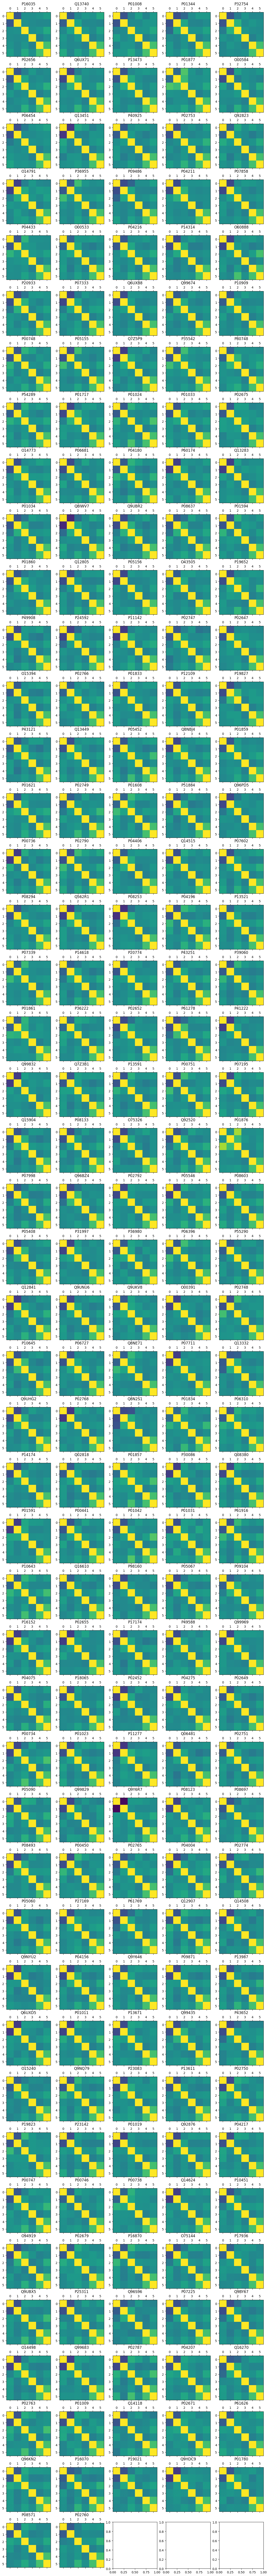

In [47]:
fig, axes = plt.subplots(nrows=46, ncols=5, figsize=(15, 150))
for i, col in enumerate(cols):
    sub = df[col].merge(y_df['updrs_1'], on='patient_id')
    cor_mat = sub[['slope','intercept', 'std_err', 'y_slope','y_intercept', 'y_std_err']].corr(numeric_only=True)
    axes[i//5][i%5].matshow(cor_mat, vmin=-1, vmax=1)
    axes[i//5][i%5].set_title(col)
plt.show()